### 사용자 홈페이지에서 Q&A AI 기능 구축하는 법
(How to build an AI that can answer questions about your website)  
  
<배우는 것>  
(1) 웹사이트를 크롤링 하는 법  
(2) 크롤링한 웹사이트를 [Embeddings API](https://platform.openai.com/docs/guides/embeddings)를 이용해 임베딩하는 법  
(3) 임베딩된 정보에 대해 간단한 검색하는 기능  

##### Pre-Requsite
- set up an OpenAI API key
- quickstart tutorial
- OpenAI Community Forum

In [ ]:
python -m venv env
source env/bin/activate
pip install -r requirements.txt

### `1. 웹 크롤러 세팅`

[Scrapy](https://github.com/scrapy/scrapy)와 같은 크롤러를 사용할 수도 있고, 아래 코드를 이용할 수도 있다.  
  
아래 코드는 루트 URL에서 시작하여 각 페이지를 방문하고 추가 링크를 찾은 다름 해당 페이지로 방문한다(같은 루트를 가진 경우)
시작하려면 필수 패키지를 가져오고, 기본 URL를 설정하고, HTMLParser 클래스를 정의한다.

In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

HTML_URL_PATTERN = r'^http[s]*://.+'

domain = "openai.com" # <- put your domain to be crawled
full_url = "https://openai.com/" # <- put your domain to be crawled with https or http

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

다음 함수는 URL을 인수로 사용하여 URL을 열고 HTML 콘텐츠를 읽습니다. 그런 다음 해당 페이지에서 발견된 모든 하이퍼링크를 반환합니다.

In [ ]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:
            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
        # Decode the HTML
        html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

목표는 OpenAI 도메인에 있는 콘텐츠만 크롤링하고 인덱스를 생성하는 것입니다. 이를 위해서는 get_hyperlinks 함수를 호출하지만 지정된 도메인에 속하지 않는 모든 URL을 필터링하는 함수가 필요합니다.

In [ ]:
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same(URL을 파싱해서 같은 도메인에 있는지 체크한다)
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link
        
        # If the link is not a URL, check if it is a relative link
        # (링크가 URL이 아니면, 관련 링크를 살핀다)
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link
        
        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)
    
    return list(set(clean_links))

크롤링 기능은 웹 스크래핑 작업 설정의 마지막 단계입니다. 사이트의 여러 페이지에 걸쳐 연결될 수 있는 동일한 페이지가 반복되는 것을 방지하기 위해 방문한 URL을 추적합니다.  
또한 HTML 태그가 없는 페이지에서 원시 텍스트를 추출하고 해당 페이지와 관련된 로컬 .txt 파일에 텍스트 콘텐츠를 기록합니다.
  
위 예제의 마지막 줄은 액세스 가능한 모든 링크를 살펴보고 해당 페이지를 텍스트 파일로 변환하는 크롤러를 실행합니다. 사이트의 크기와 복잡성에 따라 실행하는 데 몇 분이 소요됩니다.

In [ ]:
def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl (큐를 생성)
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files, 텍스트 파일을 저장할 디렉토리 생성
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files, CSV 파일을 저장할 디렉토리 생성
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling, BFS 탐색
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")

            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

### `2. 임베딩 인덱스 구축`
(Building an embeddings index)

CSV는 임베딩을 저장하는 일반적인 형식입니다. 원시 텍스트 파일(텍스트 디렉터리에 있음)을  
Pandas 데이터 프레임으로 변환하여 Python에서 이 형식을 사용할 수 있습니다.  
Pandas는 표 형식 데이터(행과 열에 저장된 데이터) 작업을 도와주는 인기 있는 오픈 소스 라이브러리입니다.  
비어 있는 빈 줄은 텍스트 파일을 복잡하게 만들어 처리하기 어렵게 만들 수 있습니다.  
간단한 기능으로 해당 줄을 제거하고 파일을 정리할 수 있습니다.

In [ ]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

텍스트를 CSV로 변환하려면 이전에 만든 텍스트 디렉터리의 텍스트 파일을 반복해야 합니다.  
각 파일을 연 후 추가 공백을 제거하고 수정된 텍스트를 목록에 추가합니다.  
그런 다음 새 줄이 제거된 텍스트를 빈 Pandas 데이터 프레임에 추가하고 데이터 프레임을 CSV 파일에 씁니다.

추가 간격과 새 줄은 텍스트를 복잡하게 만들고 임베딩 프로세스를 복잡하게 만들 수 있습니다.  
여기에 사용된 코드는 일부 문자를 제거하는 데 도움이 되지만 더 많은 불필요한 문자를 제거하는 데 유용한 타사 라이브러리나 기타 방법을 찾을 수도 있습니다.

In [ ]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

토큰화는 원시 텍스트를 CSV 파일로 저장한 후의 다음 단계입니다. 이 프로세스는 문장과 단어를 분해하여 입력 텍스트를 토큰으로 분할합니다.  
이에 대한 시각적 데모는 문서의 Tokenizer를 확인하여 볼 수 있습니다.  
  
유용한 경험 법칙은 하나의 토큰이 일반적으로 일반 영어 텍스트의 최대 4자 텍스트에 해당한다는 것입니다.  
이는 대략 단어의 3/4에 해당합니다(즉, 100개 토큰 ~= 75개 단어).

API는 임베딩을 위한 최대 입력 토큰 수에 제한이 있습니다. 한도 미만으로 나누려면, CSV 파일의 텍스트를 여러 행으로 나누어야 한다.
분할해야 할 행을 식별하기 위해 각 행의 기존 길이가 먼저 기록된다.

In [ ]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
# (ada-002 모델과 작동하도록 설계된 cl100k_base 토크나이저를 로드합니다.)
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram(행 당 토큰 수를 시각화)
df.n_tokens.hist()

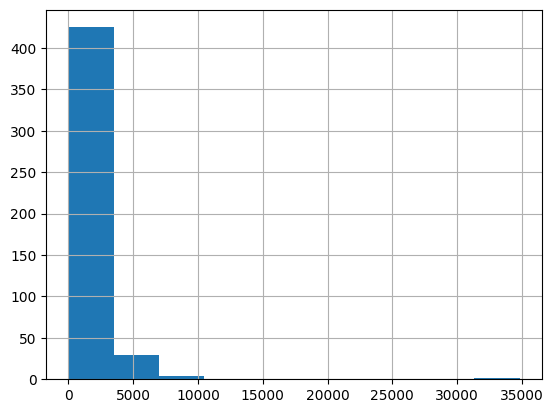

최신 임베딩 모델은 `최대 8191개의 입력 토큰`으로 입력을 처리할 수 있으므로 대부분의 행에 청크가 필요하지 않습니다.  
그러나 스크랩된 모든 하위 페이지에 해당되는 것은 아니므로 다음 코드 청크는 더 긴 줄을 더 작은 청크로 분할합니다.
==> 각 행 별로 토큰화 하였으나 행별 토큰 수를 500개 미만으로 제한한다.

In [ ]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
# (텍스트를 최대 토큰 수의 덩어리로 분할 하는 기능)
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    # 각 문장의 토큰 갯수를 저장
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens): # 각 문장과 토큰 갯수

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        # (지금까지의 토큰 수에 현재 문장의 토큰 수를 더한 값이 max_tokens 보다 큰 경우
        # 해당 청크를 청크 목록에 추가하고 chunk와 tokens_so_far를 리셋)
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".") # 토큰 목록 들을 chunks에 리스트로 추가한다.
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        # (현재 문장의 토큰 수가 최대 토큰 수(500)보다 큰 경우 다음 문장으로 이동합니다.)
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append(row[1]['text'] )

In [ ]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x))) # df['text']를 토크나이저로 인코딩한다. 
df.n_tokens.hist()

업데이트된 히스토그램을 다시 시각화하면 행이 단축된 섹션으로 성공적으로 분할되었는지 확인하는 데 도움이 될 수 있습니다.

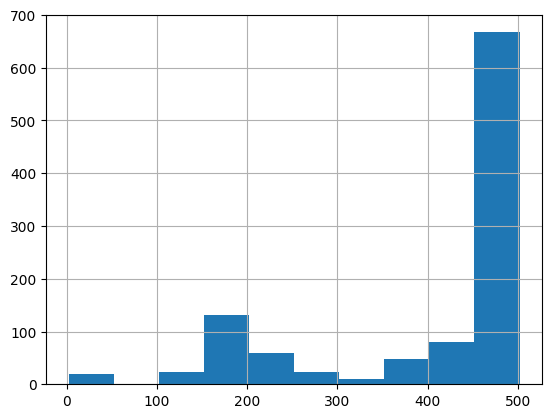

이제 콘텐츠는 더 작은 청크로 분류되며 임베딩을 생성하기 위해 새로운 `text-embedding-ada-002` 모델의 사용을 지정하는 간단한 요청을  
OpenAI API로 보낼 수 있습니다.

In [ ]:
from openai import OpenAI

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

df['embeddings'] = df.text.apply(lambda x: client.embeddings.create(input=x, engine='text-embedding-ada-002')\
                  ['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

### `3. 임베딩을 이용해 Q&A 시스템 구축`
(Building a question answer system with your embeddings)

임베딩이 준비되었으며 이 프로세스의 마지막 단계는 간단한 질문 및 답변 시스템을 만드는 것입니다.  
이는 `사용자의 질문을 받아 임베딩을 생성하고` 이를 기존 임베딩과 비교하여 스크랩된 웹사이트에서 가장 관련성이 높은 텍스트를 검색합니다.  
그런 다음 gpt-3.5-turbo-instruct 모델은 검색된 텍스트를 기반으로 자연스러운 답변을 생성합니다.
  
임베딩을 NumPy 배열로 변환하는 것이 첫 번째 단계입니다. 이는 NumPy 배열에서 작동하는 많은 기능을 제공하므로 사용 방법에 더 많은 유연성을 제공합니다. 또한 많은 후속 작업에 필요한 형식인 1차원으로 차원을 평면화합니다.  
  
임베딩을 사용한 검색은 코사인 거리를 사용하여 숫제 벡터(원시 텍스트 변화)를 비교합니다.  
OpenAI Python 패키지에는 여기서 유용한 distances_from_embeddings 함수가 내장되어 있습니다.

In [ ]:
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

In [ ]:
def create_context(question, df, max_len=1800, size="ada"):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    # 질문을 임베딩한다. 
    q_embeddings = client.embeddings.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')

    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    # 거리별로 정렬
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

텍스트는 더 작은 토큰 세트로 분할되었으므로 오름차순으로 반복하고 `텍스트를 계속 추가하는 것은 완전한 답변을 보장하는 중요한 단계`입니다.  
`원하는 것보다 더 많은 콘텐츠가 반환되는 경우 max_len을 더 작은 값으로 수정할 수도` 있습니다.

이전 단계에서는 질문과 의미상 관련된 텍스트 덩어리만 검색했으므로 답변이 포함될 수는 있지만 이에 대한 보장은 없습니다.  
`가장 가능성이 높은 결과 상위 5개를 반환`하면 답변을 찾을 확률이 더욱 높아질 수 있습니다.

In [ ]:
def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a chat completion using the question and context
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\n"},
                {"role": "user", f"content": "Context: {context}\n\n---\n\nQuestion: {question}\nAnswer:"}
            ],
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )
        return response.choices[0].message.strip()
    except Exception as e:
        print(e)
        return ""

In [ ]:
answer_question(df, question="What day is it?", debug=False)

answer_question(df, question="What is our newest embeddings model?")

answer_question(df, question="What is ChatGPT?")

시스템이 예상되는 질문에 대답할 수 없는 경우, 알려질 것으로 예상되는 정보가 실제로 포함되었는지 여부를 확인하기 위해 원시 텍스트 파일을 검색하는 것이 좋습니다. `처음에 수행된 크롤링 프로세스는 제공된 원래 도메인 외부의 사이트를 건너뛰도록 설정`되었으므로 `하위 도메인 설정이 있는 경우 해당 지식이 없을 수 있습니다`.  
  
현재는 질문에 대답하기 위해 HTML 임베딩(df)가 매번 인수로 들어가지만, 임베딩을 CSV 파일에 저장하는 대신 벡터 DB 솔루션을 생각해 볼 수 있다.